# Identification of Urban Regions: Community Detection Techniques

In [2]:
import networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import cityImage as ci, regions as ur
import community 
import igraph 

from networkx.algorithms import community as nxcomm
from shapely.geometry import Point, mapping
import warnings
warnings.simplefilter(action="ignore")

pd.options.display.float_format = '{:20.2f}'.format
pd.options.mode.chained_assignment = None
%matplotlib inline

C:\Users\gfilo\AppData\Local\Temp\ipykernel_10644\76437843.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd


In [4]:
## Crs and names
epsg = 26986
city_name = 'Boston'
crs = 'EPSG'+str(epsg)
input_path = 'data/'+city_name

## Loading necessary files

In [5]:
# primal graph
nodes_graph = gpd.read_file(input_path+'_nodes.gpkg')
edges_graph = gpd.read_file(input_path+'_edges.gpkg')
nodes_graph.index, edges_graph.index = nodes_graph.nodeID, edges_graph.edgeID
nodes_graph.index.name, edges_graph.index.name = None, None

# primal graph with barrier removal
nodes_graph_nb = gpd.read_file(input_path+"_nodes_noBarriers.gpkg", driver='GPKG')
edges_graph_nb = gpd.read_file(input_path+"_edges_noBarriers.gpkg", driver='GPKG')
nodes_graph_nb.index, edges_graph_nb.index = nodes_graph_nb.nodeID, edges_graph_nb.edgeID
nodes_graph_nb.index.name, edges_graph_nb.index.name = None, None


# dua graph
nodesDual_graph = gpd.read_file(input_path+"_nodesDual.gpkg", driver='GPKG')
edgesDual_graph = gpd.read_file(input_path+"_edgesDual.gpkg", driver='GPKG')
nodesDual_graph.index = nodesDual_graph.edgeID
nodesDual_graph.index.name, edgesDual_graph.index.name = None, None

nodesDual_graph_nb = gpd.read_file(input_path+"_nodesDual_noBarriers.gpkg", driver='GPKG')
edgesDual_graph_nb = gpd.read_file(input_path+"_edgesDual_noBarriers.gpkg", driver='GPKG')
nodesDual_graph_nb.index = nodesDual_graph_nb.edgeID
nodesDual_graph_nb.index.name, edgesDual_graph_nb.index.name = None, None

# barriers
barriers = gpd.read_file(input_path+'_barriers.gpkg', driver='GPKG')

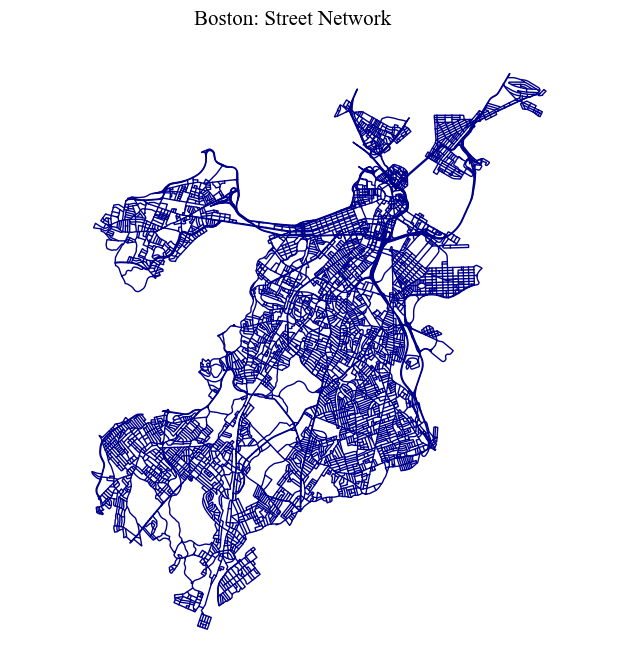

In [13]:
fig = ci.plot_gdf(edges_graph, scheme = None, black_background = False, figsize = (7,7), title = city_name+': Street Network', color = 'darkblue')

## Districts identification from the Dual Graph
### Entire Street Network

In [ ]:
## creating graph that can be converted to igraph
nodesDual_graphRX, edgesDual_graphRX = ur.reset_index_dual(nodesDual_graph, edgesDual_graph)
dual_graphRX = ur.dual_graphIG_fromGDF(nodesDual_graphRX, edgesDual_graphRX)

In [11]:
# Clauset-Newman-Moore greedy modularity maximization
clauset = list(nxcomm.greedy_modularity_communities(dual_graphRX))
for comm, n in enumerate(clauset):
    nodesDual_graphRX.loc[nodesDual_graphRX.index.isin(list(n)), 'ca'] = int(comm)
    
# label_propagation
label_propagation = nxcomm.label_propagation_communities(dual_graphRX)
for comm, n in enumerate(label_propagation):
    nodesDual_graphRX.loc[nodesDual_graphRX.index.isin(list(n)), 'lp'] = int(comm)

# louvain
louvain = community.best_partition(dual_graphRX, weight='deg')
nodesDual_graphRX['lo'] = nodesDual_graphRX.index.map(louvain)

In [13]:
dual_graphIG = ur.from_nx_to_igraph(dual_graphRX, 'deg')
# walktrap
walktrap = dual_graphIG.community_walktrap(weights = dual_graphIG.es['weight'])
# Convert the result to a clustering
clusters = walktrap.as_clustering()

# Ensure there is a 'wa' column to store community membership
nodesDual_graphRX['wa'] = -1

# Assign community membership to the nodes in nodesDual_graphRX
for comm, n in enumerate(clusters):
    nodesDual_graphRX.loc[nodesDual_graphRX.index.isin(n), 'wa'] = int(comm)

In [14]:
columns = ['ca', 'lp','wa', 'lo']
to_merge = ['edgeID']+columns
districts_dual = pd.merge(edges_graph, nodesDual_graphRX[to_merge], left_on = "edgeID", right_on = "edgeID", how= "left")

for i in columns:
    districts_dual[i] = districts_dual[i].astype(int) 

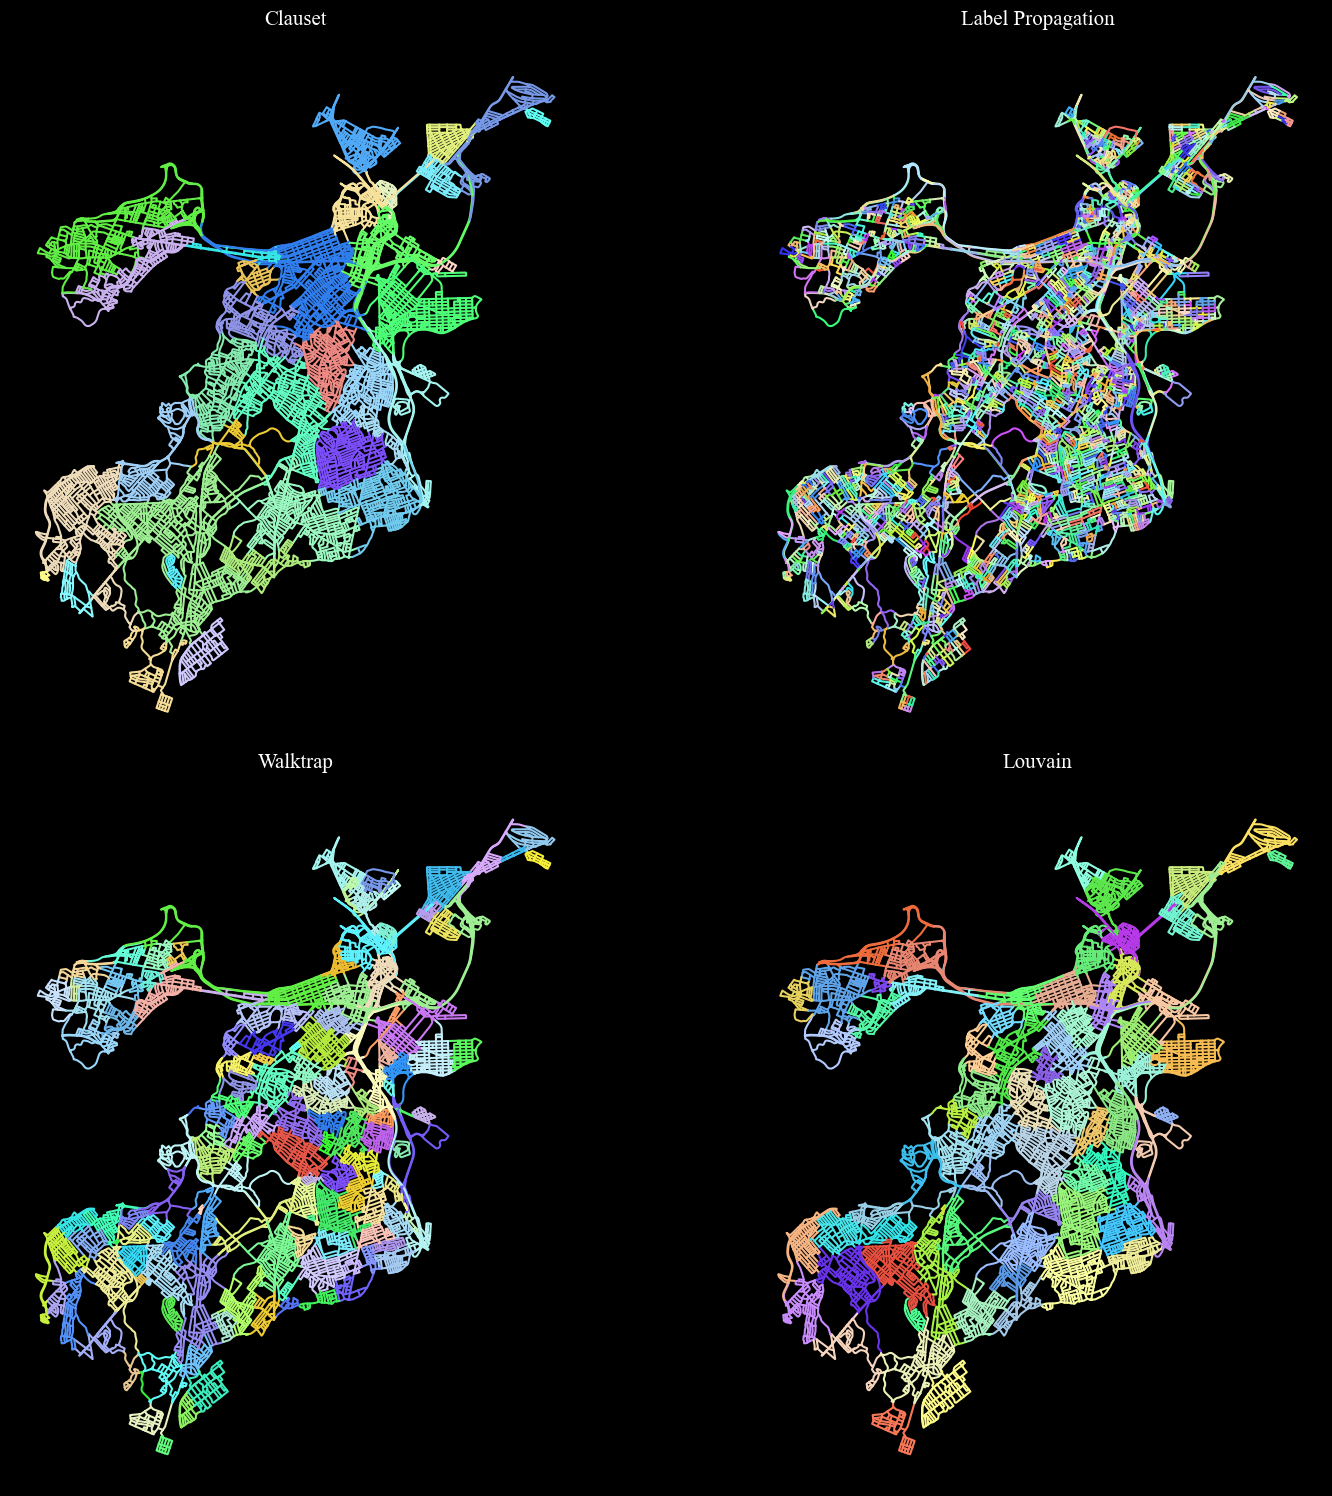

In [18]:
titles = ['Clauset', 'Label Propagation', 'Walktrap', 'Louvain']

nlabels = max([len(districts_dual[column].unique()) for column in columns])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_grid_gdf_columns(districts_dual, columns = columns, titles = titles, geometry_size = 1.5, cmap = cmap, black_background = True, 
                  legend = False, figsize = (15, 15), ncols = 2, nrows = 2)

### With Barrier removal

In [19]:
## creating graph usable in igraph - barriers removal
nodesDual_graphRX_nb, edgesDual_graphRX_nb = ur.reset_index_dual(nodesDual_graph_nb, edgesDual_graph_nb)
dual_graphRX_nb = ur.dual_graphIG_fromGDF(nodesDual_graphRX_nb, edgesDual_graphRX_nb)

#### Algorithms

In [20]:
# Clauset-Newman-Moore greedy modularity maximization
clauset_nb = list(nxcomm.greedy_modularity_communities(dual_graphRX_nb))
for comm, n in enumerate(clauset_nb):
    nodesDual_graphRX_nb.loc[nodesDual_graphRX_nb.index.isin(list(n)), 'ca_nb'] = int(comm) 

# label_propagation
label_propagation_nb = nxcomm.label_propagation_communities(dual_graphRX_nb)
for comm, n in enumerate(label_propagation_nb):
    nodesDual_graphRX_nb.loc[nodesDual_graphRX_nb.index.isin(list(n)), 'lp_nb'] = int(comm)  

# louvain
louvain_nb = community.best_partition(dual_graphRX_nb, weight='rad')
nodesDual_graphRX_nb['lo_nb'] = nodesDual_graphRX_nb.index.map(louvain_nb)

dual_graphIG_nb = ur.from_nx_to_igraph(dual_graphRX, 'deg')

# walktrap
walktrap_nb = dual_graphIG_nb.community_walktrap(weights = dual_graphIG_nb.es['weight'])
# Convert the result to a clustering
clusters_nb = walktrap_nb.as_clustering()

# Ensure there is a 'wa' column to store community membership
nodesDual_graphRX_nb['wa'] = -1

# Assign community membership to the nodes in nodesDual_graphRX
for comm, n in enumerate(clusters_nb):
    nodesDual_graphRX_nb.loc[nodesDual_graphRX_nb.index.isin(n), 'wa_nb'] = int(comm)

In [ ]:
columns_nb = ['ca_nb', 'lp_nb','wa_nb', 'lo_nb']
to_merge = ['edgeID']+columns_nb
districts_dual = pd.merge(districts_dual, nodesDual_graphRX_nb[to_merge], left_on = "edgeID", right_on = "edgeID", how= "left")
districts_dual[columns_nb] = districts_dual[columns_nb].where(~districts_dual[columns_nb].isnull(), 999999)

for i in columns_nb:
    districts_dual[i] = districts_dual[i].astype(int) 

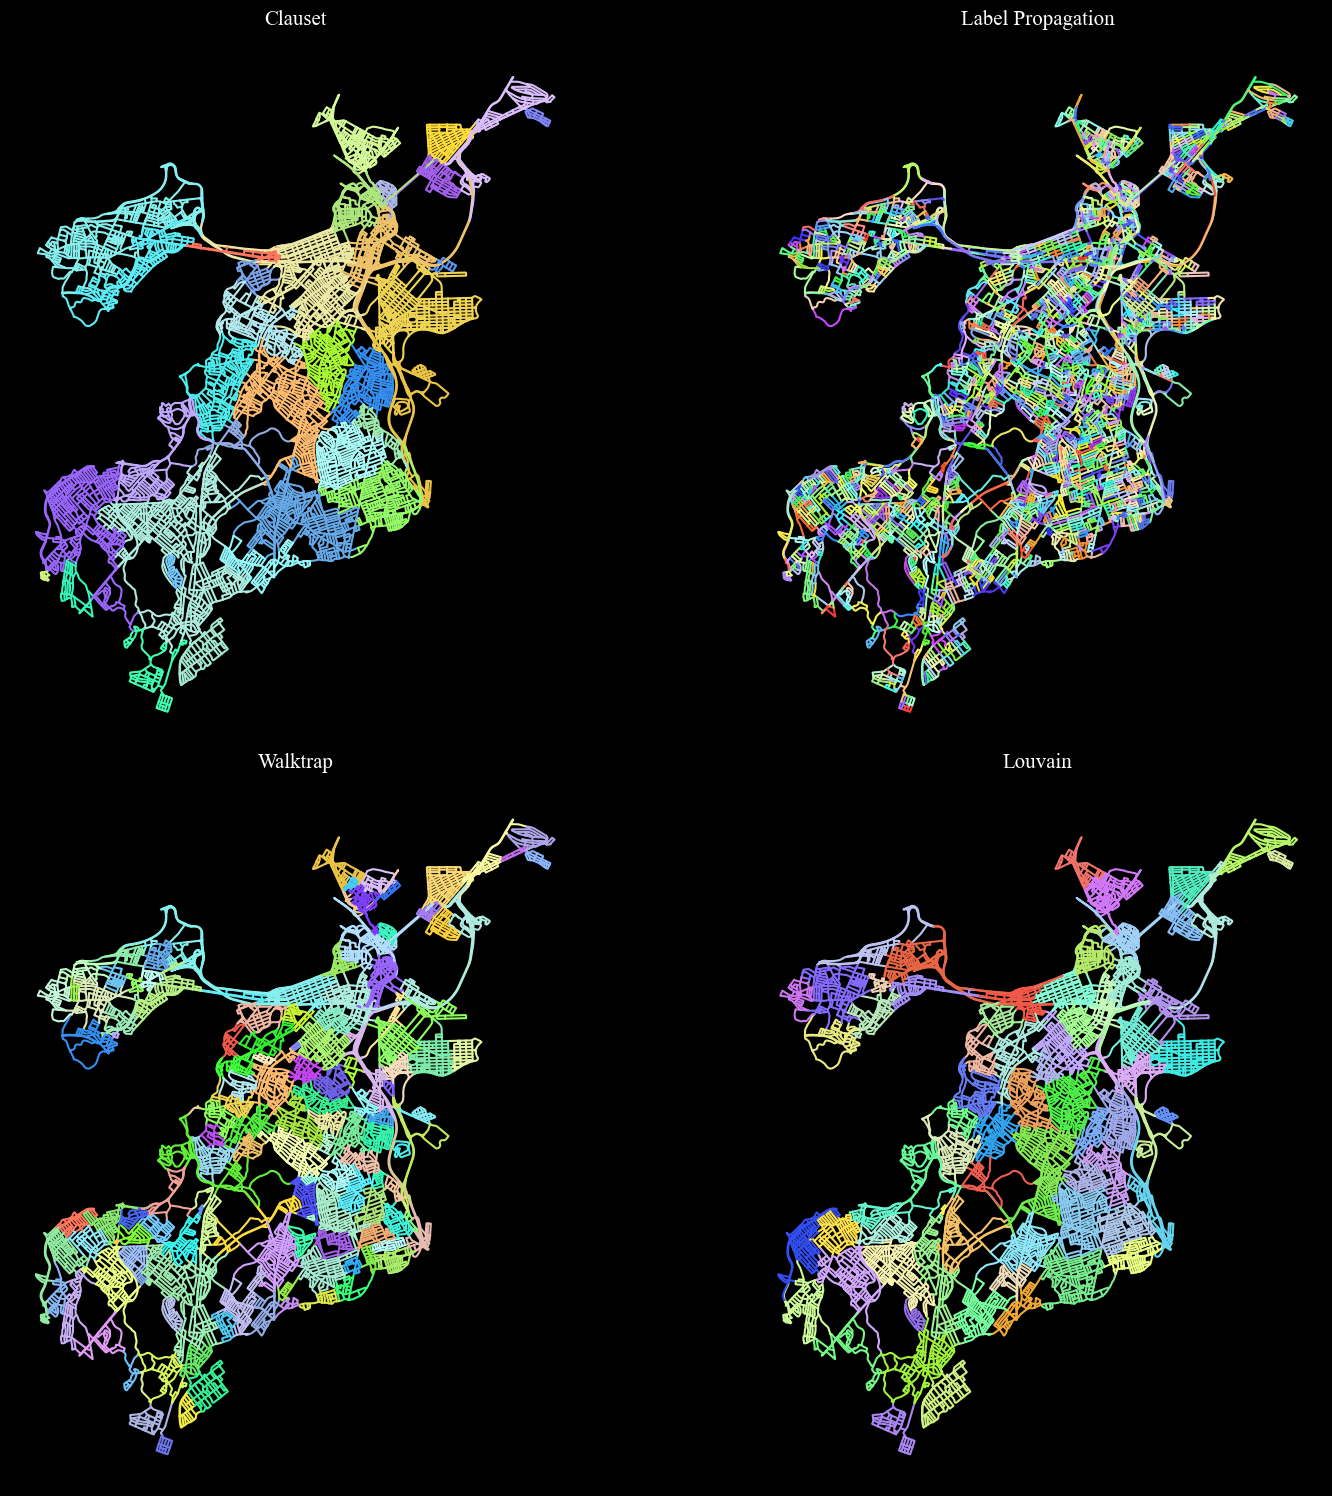

In [26]:
titles = ['Clauset', 'Label Propagation', 'Walktrap', 'Louvain']

nlabels = max([len(districts_dual[column].unique()) for column in columns_nb])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_grid_gdf_columns(districts_dual, columns = columns, titles = titles, geometry_size = 1.5, cmap = cmap, black_background = True, 
                  legend = False, figsize = (15, 15), ncols = 2, nrows = 2)

## Districts Identification from the Primal Graph
### Entire Street Network

In [24]:
## creating graph usable in igraph
nodes_graphRX, edges_graphRX = ur.reset_index_gdfs(nodes_graph, edges_graph)
graphRX = ci.graph_fromGDF(nodes_graphRX, edges_graphRX, nodeID = "IG_nodeID")

#### Algorithms 

In [25]:
# Clauset-Newman-Moore greedy modularity maximization
clauset = list(nxcomm.greedy_modularity_communities(graphRX))
for comm, n in enumerate(clauset):
    nodes_graphRX.loc[nodes_graphRX.index.isin(list(n)), 'ca'] = int(comm)

# label_propagation
label_propagation = nxcomm.label_propagation_communities(graphRX)
for comm, n in enumerate(label_propagation):
    nodes_graphRX.loc[nodes_graphRX.index.isin(list(n)), 'lp'] = int(comm) 

# louvain
louvain = community.best_partition(graphRX, weight='length')
nodes_graphRX['lo'] = nodes_graphRX.index.map(louvain)

# walktrap
graphIG = ur.from_nx_to_igraph(graphRX, 'length')

walktrap = graphIG.community_walktrap(weights = graphIG.es['weight'])
# Convert the result to a clustering
clusters = walktrap.as_clustering()

# Ensure there is a 'wa' column to store community membership
nodes_graphRX['wa'] = -1

# Assign community membership to the nodes in nodesDual_graphRX
for comm, n in enumerate(clusters):
    nodes_graphRX.loc[nodes_graphRX.index.isin(n), 'wa'] = int(comm)

In [26]:
columns = ['ca', 'lp','wa', 'lo']
to_merge = ['nodeID']+columns
nodes_districts = pd.merge(nodes_graph, nodes_graphRX[to_merge], on = "nodeID", how= "left")

for i in columns:
    nodes_districts[i] = nodes_districts[i].astype(int)

### with Barrier removal

In [28]:
## creating graph usable in igraph - barriers removal
nodes_graphRX_nb, edges_graphRX_nb = ur.reset_index_gdfs(nodes_graph_nb, edges_graph_nb)
graphRX_nb = ci.graph_fromGDF(nodes_graphRX_nb, edges_graphRX_nb, nodeID = "IG_nodeID")

#### Algorithms 

In [29]:
# Clauset-Newman-Moore greedy modularity maximization
clauset_nb = list(nxcomm.greedy_modularity_communities(graphRX_nb))
for comm, n in enumerate(clauset_nb):
    nodes_graphRX_nb.loc[nodes_graphRX_nb.index.isin(list(n)), 'ca_nb'] = int(comm)

# label_propagation
label_propagation_nb = nxcomm.label_propagation_communities(graphRX_nb)
for comm, n in enumerate(label_propagation_nb):
    nodes_graphRX_nb.loc[nodes_graphRX_nb.index.isin(list(n)), 'lp_nb'] = int(comm) 

# louvain
louvain_nb = community.best_partition(graphRX_nb, weight='length')
nodes_graphRX_nb['lo_nb'] = nodes_graphRX_nb.index.map(louvain_nb)

# walktrap
graphIG_nb = ur.from_nx_to_igraph(graphRX_nb, 'length')

walktrap_nb = graphIG_nb.community_walktrap(weights = graphIG_nb.es['weight'])
# Convert the result to a clustering
clusters_nb = walktrap_nb.as_clustering()

# Ensure there is a 'wa' column to store community membership
nodes_graphRX_nb['wa_nb'] = -1

# Assign community membership to the nodes in nodesDual_graphRX
for comm, n in enumerate(clusters_nb):
    nodes_graphRX_nb.loc[nodes_graphRX_nb.index.isin(n), 'wa_nb'] = int(comm)

In [30]:
columns_nb = ['ca_nb', 'lp_nb', 'wa_nb', 'lo_nb']
to_merge = ['nodeID']+columns_nb

nodes_districts = pd.merge(nodes_districts, nodes_graphRX_nb[to_merge], on = "nodeID", how= "left")
nodes_districts[columns_nb] = nodes_districts[columns_nb].where(~nodes_districts[columns_nb].isnull(), 999999)

for i in columns:
    nodes_districts[i] = nodes_districts[i].astype(int)
    
nodes_districts.index = nodes_districts['nodeID']
nodes_districts.index.name = None

#### From nodes to edges (as this was on the Primal Graph)

In [31]:
to_assign = columns + columns_nb
districts_primal = edges_graph.copy()

for column in to_assign:
    districts_primal = ci.districts_to_edges_from_nodes(nodes_districts, districts_primal, column)

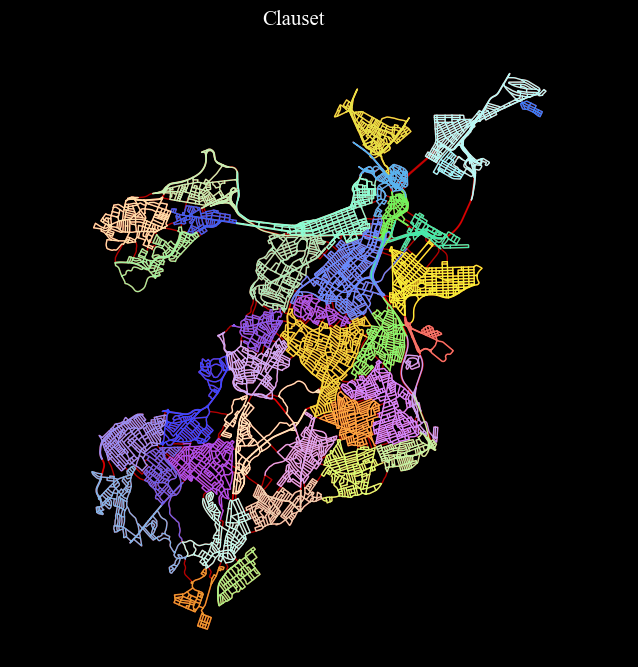

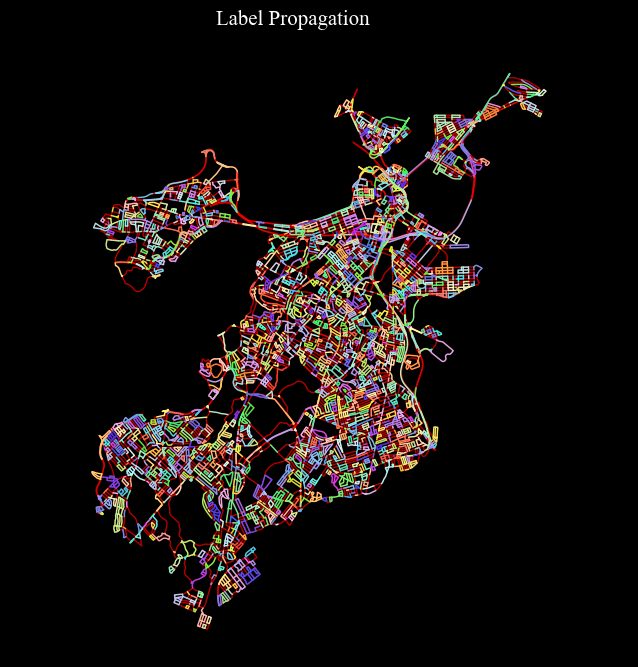

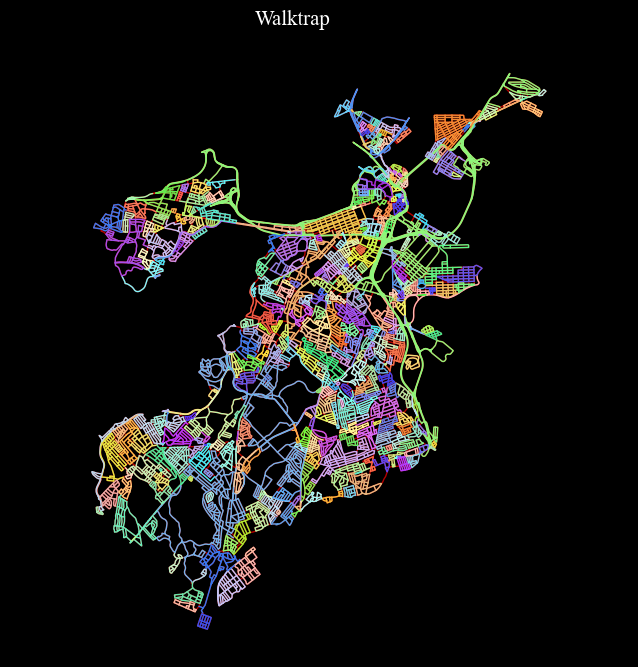

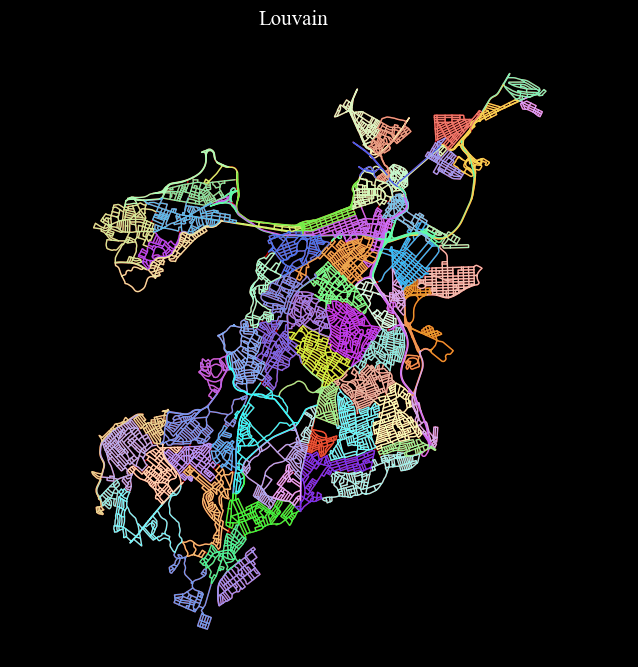

In [32]:
to_show = ['ca_uv', 'lp_uv', 'wa_uv', 'lo_uv']
titles = ['Clauset', 'Label Propagation', 'Walktrap', 'Louvain']
base_map = {'base_map_gdf' : edges_graph, 'base_map_alpha' : 0.7, 'base_map_color' : 'red', 'base_map_zorder' : 0,
           'base_map_geometry_size' : 1}

for n, column in enumerate(to_show):
    cmap = ci.rand_cmap(nlabels = len(districts_primal[column].unique()), type_color='bright')
    gdf = districts_primal[districts_primal[column] != 999999].copy()
    fig = ci.plot_gdf(gdf, column = column, title = titles[n], geometry_size = 1, cmap = cmap, 
                  black_background = True, legend = False, figsize = (7,7), **base_map)    

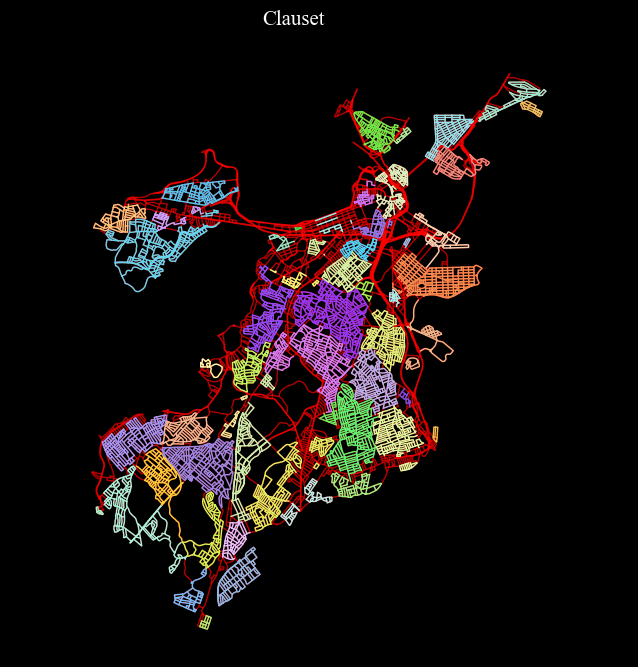

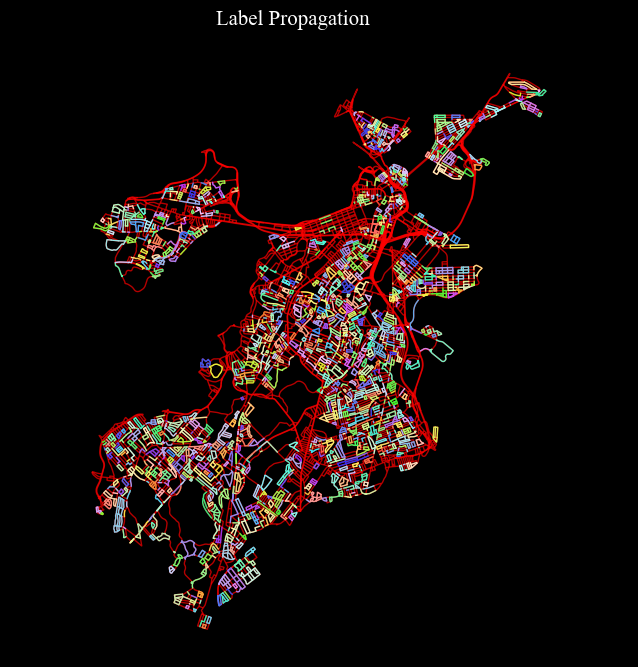

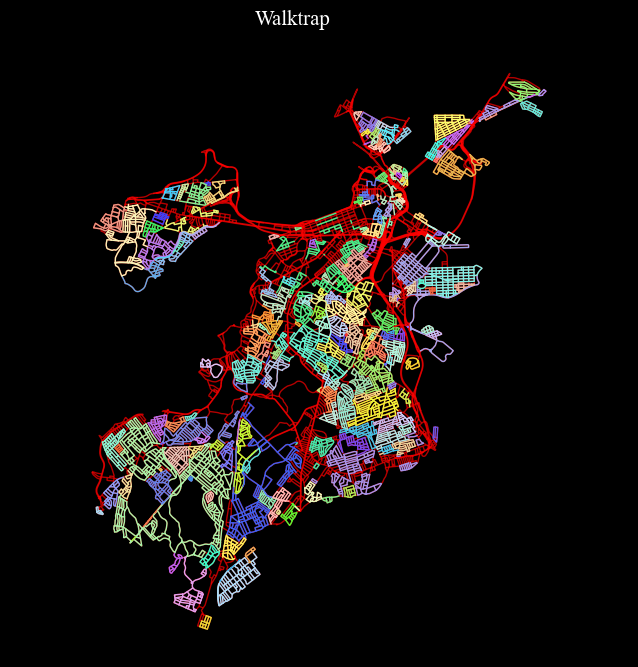

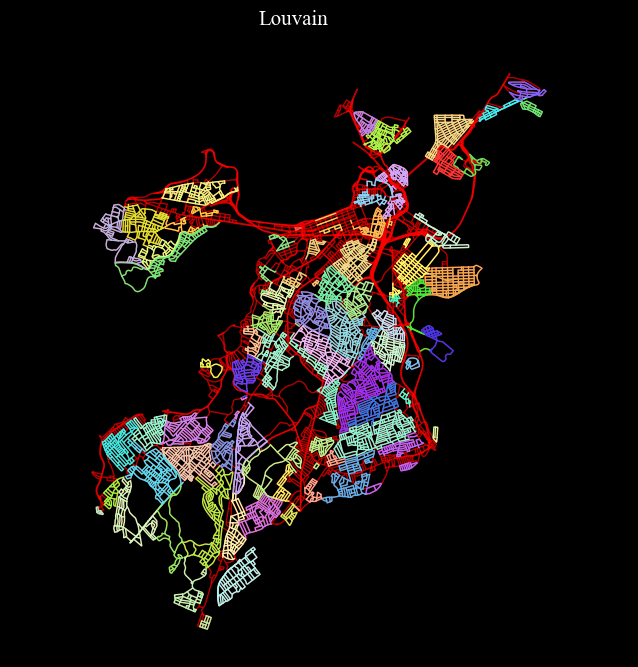

In [33]:
to_show = ['ca_nb_uv', 'lp_nb_uv', 'wa_nb_uv', 'lo_nb_uv']
titles = ['Clauset', 'Label Propagation', 'Walktrap', 'Louvain']
base_map = {'base_map_gdf' : edges_graph, 'base_map_alpha' : 0.7, 'base_map_color' : 'red', 'base_map_zorder' : 0,
           'base_map_geometry_size' : 1}

for n, column in enumerate(to_show):
    cmap = ci.rand_cmap(nlabels = len(districts_primal[column].unique()), type_color='bright')
    gdf = districts_primal[districts_primal[column] != 999999].copy()
    fig = ci.plot_gdf(gdf, column = column, title = titles[n], geometry_size = 1, cmap = cmap, 
                  black_background = True, legend = False, figsize = (7,7), **base_map)    

## Exporting

In [171]:
# saving
districts_dual.to_file(input_path+"_districts_dual.gpkg", driver='GPKG')
districts_primal.to_file(input_path+"_districts_primal.gpkg", driver='GPKG')